# ARMA Model

Import Libraries

In [30]:
import pandas as pd
from data import OpenmeteoAPI, SQLRespository
import sqlite3
from config import settings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


### Prepare Data

API CALL

For the purpose of this project, i will be getting my PM2.5 data using [Open Metro](https://open-meteo.com/) Api just as if have done in `air_quality1.ipynb` Notebook.

In [13]:
# open_api = OpenmeteoAPI()
# record = open_api.getPM2_5(lat=7.403546223182103, lon=3.932032049519837, start_date="2024-01-01", end_date="2024-12-18")
# record

In [14]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
repo = SQLRespository(connection=connection)

In [15]:
# repo.insert_table(table_name="PM2_5", records=record)

In [16]:
df = repo.read_table(table_name="PM2_5")

# Rename pm2_5 to PM2.5
df.rename(columns={"pm2_5" : "PM2.5"}, inplace=True)
df

,PM2.5
date,
2023-12-31 23:00:00+00:00,132.699997
2024-01-01 00:00:00+00:00,131.300003
2024-01-01 01:00:00+00:00,128.100006
2024-01-01 02:00:00+00:00,126.199997
2024-01-01 03:00:00+00:00,124.800003
...,...
2024-12-18 18:00:00+00:00,116.400002
2024-12-18 19:00:00+00:00,140.199997
2024-12-18 20:00:00+00:00,154.100006


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8472 entries, 2023-12-31 23:00:00+00:00 to 2024-12-18 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   8472 non-null   float64
dtypes: float64(1)
memory usage: 132.4+ KB


The data should be format to Series.} 

In [18]:
y = df["PM2.5"]
print(type(y))
y

<class 'pandas.core.series.Series'>


date
2023-12-31 23:00:00+00:00    132.699997
2024-01-01 00:00:00+00:00    131.300003
2024-01-01 01:00:00+00:00    128.100006
2024-01-01 02:00:00+00:00    126.199997
2024-01-01 03:00:00+00:00    124.800003
                                ...    
2024-12-18 18:00:00+00:00    116.400002
2024-12-18 19:00:00+00:00    140.199997
2024-12-18 20:00:00+00:00    154.100006
2024-12-18 21:00:00+00:00    159.699997
2024-12-18 22:00:00+00:00    155.500000
Name: PM2.5, Length: 8472, dtype: float64

In [19]:
assert isinstance(y, pd.Series), f"`y` should be Series not type {type(y)}"
assert y.isnull().sum() == 0, f"`y` should not contain any null value"

### Explore

Plot ACF plot for data `y`

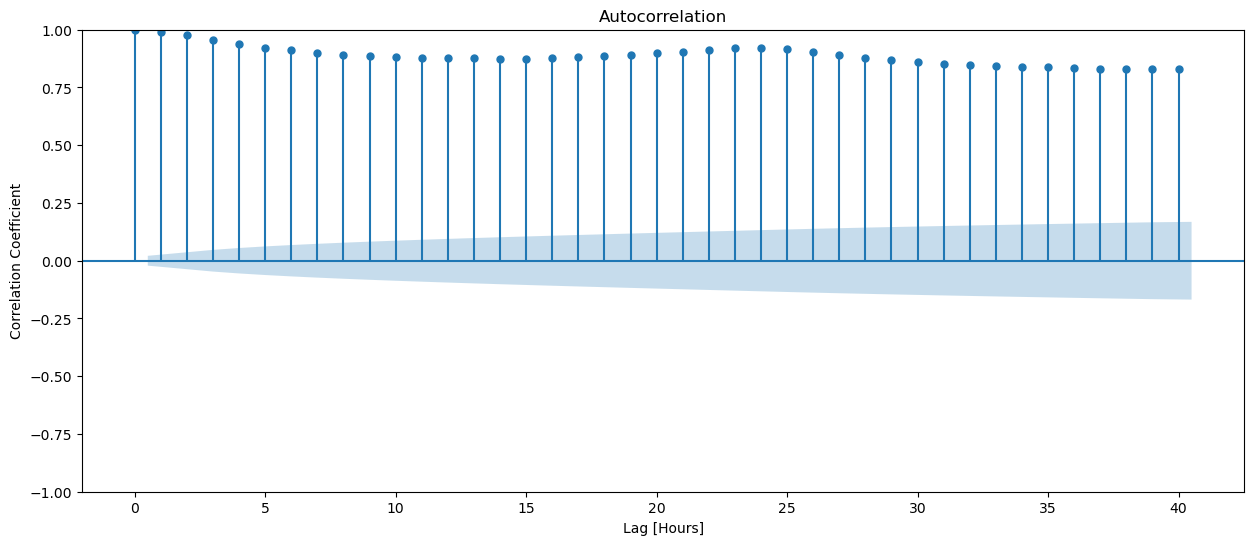

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

Plot PACF plot for data `y`

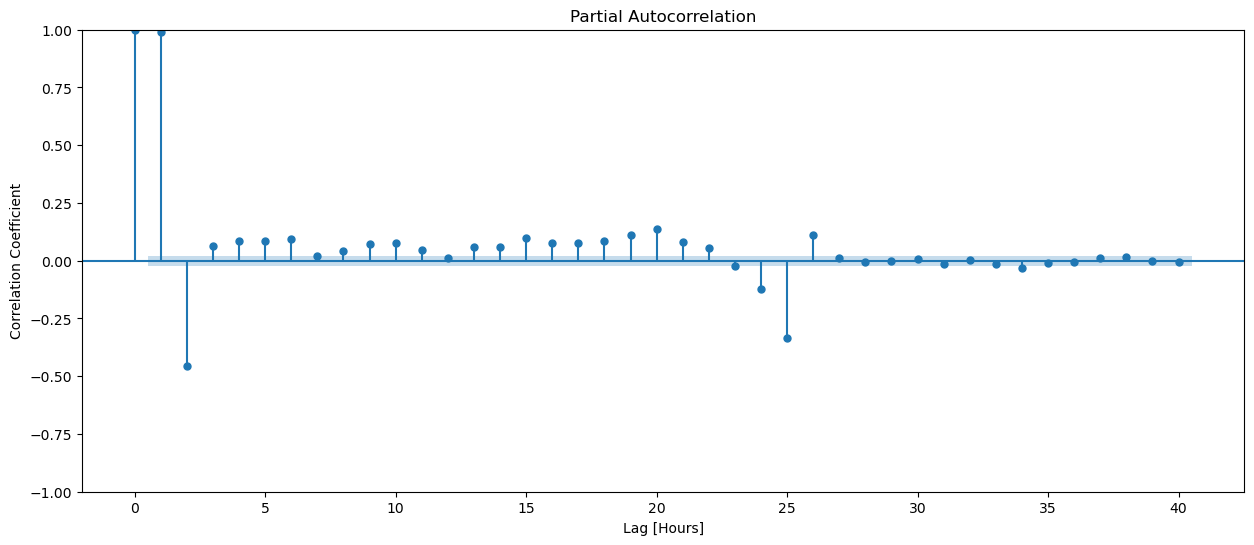

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

### Split

Split `y` into training and test set. The first 95% should be training set and the remaining 5% should be in the test set. 

In [31]:
cut_off = int(len(y) * 0.95)
y_train = y.iloc[:cut_off]
y_test = y.iloc[cut_off:]

In [42]:
y_mean =  y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print(f"Mean PM2.5 Reading: {y_mean.round(2)}")
print(f"Baseline MAE: {baseline_mae.round(2)}")

Mean PM2.5 Reading: 34.69
Baseline MAE: 26.44


### Iterate

Hyperparameter tuning

In [43]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

Training a model with every combination of hyperparameters in `p_params` and `q_params`. Everytime the model is trained, mean absolute error is calculated and then save to dictionary

In [ ]:
# Create dictionary to save MAE
import time


mae_grid = {}

# Outer loop : iterate through possible valuse for `p`
for p in p_params:
    # Create key-value pair. Key is `p` and value is empty list
    mae_grid[p] = list()
    # Inner loop : Iterate possible values of `q`
    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        # Combination of hyperparameters for the model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds")
        # Generate in-sample training predictions
        y_pred = model.predict()
        # Calculate training MAE
        


## Build Model

### Baseline

Calculate the mean absolute error for the model

In [22]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)


print(f"Mean P2.5 reading: {y_mean.round(2)}")
print(f"Baseline MAE: {baseline_mae.round(2)}")


NameError: name 'y_train' is not defined

### Iterate

Instantiate **AutoReg** model and fit training data using lag of 26